# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

In [334]:
# Setup
import pandas as pd
import numpy as np
from netml.pparser.parser import PCAP
from collections import defaultdict
from datetime import datetime, timedelta
import pickle
import math
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import random
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 100)

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.

In [11]:
pcap_raw = PCAP('./data/netflix.pcap')
pcap_raw.pcap2pandas()
pcap_df = pcap_raw.df

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

<font color="green">**I noticed that the PCAP when stored as a CSV does not have the IP addresses of the source and destination. This means that the DNS queries are insufficient to filter the addresses. Instead, I performed my analysis on the raw pcap, since we can filter the source / destination of those IPs.**</font>

<font color="green">We care about the data in `dns_query` and `dns_resp`. These are stored as tuples, likely because DNS queries can have multiple queries URLs per request. Let's check if that's actually happening in this pcap, or if we can just reduce them both to single strings. </color>

In [12]:
print(max(pcap_df["dns_query"].map(lambda tup: 0 if not tup else len(tup))))
print(max(pcap_df["dns_resp"].map(lambda tup: 0 if not tup else len(tup))))

1
1


<font color="green">They are all length 1, so let's select all resolved DNS queries and create columns for their URL queried and the IP response</font>

In [13]:
dns_queries = pcap_df[pcap_df["is_dns"] & (pcap_df["dns_resp"].notnull())].copy()
dns_queries["query_url"] = dns_queries["dns_query"].map(lambda tup: tup[0])
dns_queries["query_resp"] = dns_queries["dns_resp"].map(lambda tup: tup[0])

<font color="green">Now we can just filter from those of Netflix (from associated IPs) and filter the responses</font>

In [17]:
# Prompt => Formalize the pseudocode into a pandas df query
# target_domains = ["nflxvideo", "netflix", "nflxso", "nflxext"]
# pdf[pdf["is_dns"] & (one of target_domains in pdf["dns_query"]])
target_domains = ["nflxvideo", "netflix", "nflxso", "nflxext"]
filtered_dns_queries = dns_queries[dns_queries["query_url"].str.contains("|".join(target_domains), na=False)]
all_netflix_ips=set(filtered_dns_queries["query_resp"])
only_netflix_traffic = pcap_df[pcap_df["ip_dst"].isin(all_netflix_ips) | pcap_df["ip_src"].isin(all_netflix_ips)]
print(f"Found {len(only_netflix_traffic)} netflix packets (filtering removed {len(pcap_df) - len(only_netflix_traffic)} non-netflix packets)")

Found 138633 netflix packets (filtering removed 2838 non-netflix packets)


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

<font color="green">**Theory 1**
Although the data inside the packets is encrypted and thus unreadable, the resolution will directly correlate to the amount of bytes transmitted from the server to the client. Since the number of bytes sent is visible, we can use this as a proxy for resolution. I'm currently in Math of ML, and we actually used linear regression as a classifier in a similar context: if we have our linear regression model output a number that's proportional to the magnitude of data sent to and from a server, we can classify the resolution in scaled buckets. We can also consider non-linear relationships through data transformation. I tried both logging and exponentiating the outputs, reflecting the non-linear relationship between resolution and bytes transmitted per unit of time.</font>

<font color="green">**Theory 2 (post-hoc...)**
I found that this model was inaccurate for very low / high resolutions. This is likely because the 480p and 1080p resolutions used may happen in bursts. Even if someone is streaming at 720p consistently and a network event happens that causes them to buffer slightly less data, then the drop to 480p may not be wholly reflected in the number of bytes transmitted. Therefore, I also considered other features such as bytes in flight and number of parallel connections: although these inform resolution, they aren't directly related to a single output metric of "bytes per second." Therefore I chose a different classifier model, random forests, to reflect these other relationships.</font>

<font color="green">In order to calculate statistics about the flows, we first need to split the packets into different flows. I will maintain (peer ip) => flows[] which are separated by durations of >10 seconds or more</font>

In [52]:
PCAP_HOST = "192.168.43.72"
SEP_TIME = 30 # seconds

pcap_df["peer"] = np.where(pcap_df["ip_src"] == PCAP_HOST, pcap_df["ip_dst"], pcap_df["ip_src"])
pcap_df["down"] = pcap_df["ip_dst"] == PCAP_HOST

flows = defaultdict(list)

for idx, row in pcap_df.iterrows():
    peer = row["peer"]
    if not flows[peer]:
        flows[peer].append([row])
    else:
        last = flows[peer][-1][-1]
        if row["time"] - last["time"] < SEP_TIME:
            flows[peer][-1].append(row)
        else:
            flows[peer].append([row])

<font color="green">Now we can iterate over the flows (which are in a form more similar to what we will run our analysis on</font>

In [66]:
import pandas as pd

records = []

for peer, list_of_flows in flows.items():
    for flow_packets in list_of_flows:
        if not flow_packets:
            continue
    
        n_packets = len(flow_packets)
        total_bytes = sum(p["length"] for p in flow_packets)
        bytes_down = sum(p["length"] for p in flow_packets if p["down"])
        bytes_up = total_bytes - bytes_down
        n_down = sum(1 for p in flow_packets if p["down"])
        n_up = n_packets - n_down
    
        start = flow_packets[0]["time"]
        end = flow_packets[-1]["time"]
        duration = max(end - start, 1)  # avoid division by zero
    
        bitrate_down = bytes_down * 8 / duration  # bits per second
        bitrate_up = bytes_up * 8 / duration
    
        records.append({
            "peer": peer,
            "total_bytes": total_bytes,
            "bytes_up": bytes_up,
            "bytes_down": bytes_down,
            "n_packets": n_packets,
            "n_up": n_up,
            "n_down": n_down,
            "bitrate_up": bitrate_up,
            "bitrate_down": bitrate_down,
            "duration": duration,
        })

flows_df = pd.DataFrame(records)

Finally, we can consider the distributions of these features statistically and visually

In [67]:
for feat in ["total_bytes", "bytes_up", "bytes_down", "n_packets", "bitrate_up"]:
    print("\n",flows_df[feat].describe())


 count    1.320000e+02
mean     1.600845e+05
std      1.676556e+06
min      4.600000e+01
25%      1.200000e+02
50%      4.010000e+02
75%      2.684000e+03
max      1.925861e+07
Name: total_bytes, dtype: float64

 count    1.320000e+02
mean     2.834036e+04
std      2.840745e+05
min      0.000000e+00
25%      9.000000e+01
50%      2.460000e+02
75%      1.733500e+03
max      3.263517e+06
Name: bytes_up, dtype: float64

 count    1.320000e+02
mean     1.317442e+05
std      1.392500e+06
min      0.000000e+00
25%      0.000000e+00
50%      6.600000e+01
75%      9.995000e+02
max      1.599510e+07
Name: bytes_down, dtype: float64

 count       132.000000
mean       1071.750000
std       11141.590908
min           1.000000
25%           2.000000
50%           4.000000
75%          24.000000
max      127986.000000
Name: n_packets, dtype: float64

 count     132.0
unique     93.0
top       432.0
freq       18.0
Name: bitrate_up, dtype: float64


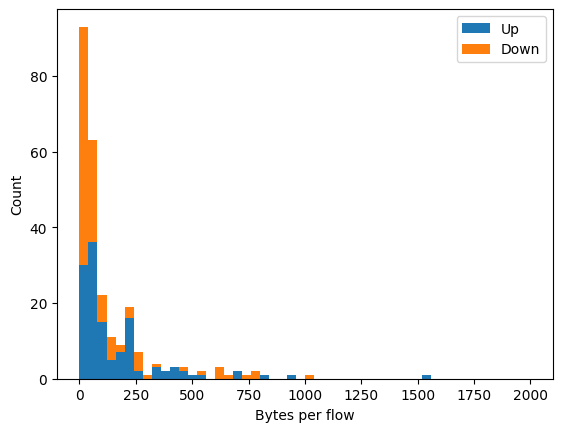

In [71]:
import matplotlib.pyplot as plt

plt.hist(
    [flows_df["bytes_up"] / flows_df["duration"], flows_df["bytes_down"] / flows_df["duration"]],
    bins=50,
    range=(0, 2000),
    stacked=True,
    label=["Up", "Down"],
)
plt.xlabel("Bytes per flow")
plt.ylabel("Count")
plt.legend()
plt.show()

**Write a brief justification for the features that you have chosen.**

<font color="green">I justified the features that relate to the number of bytes transmitted in the section above. However, I ultimately found that this collection was insufficient. Instead, I'll justify why I added "bytes in flight" and "parallel flows.</font>

<font color="green">First, I found that the linear regression model failed to accurately predict when resolution was very low, e.g. 480p. I theorize that this is likely because most connections have the bandwidth for 720p and therefore request the larger format. Instead, temporary network issues such as misrouted packets or high latency delays their display. In this case, the bandwidth is still high, but the actual experience is lower. The number of packets in flight reflects these issues, helping prediction accuracy. Similarly, the client will react to changes in resolution by preparing appropriate network infrastructure: for example, opening additional parallel connections.</font>

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [80]:
flow_sessions = [] 

for peer, list_of_flows in flows.items():
    for flow_packets in list_of_flows:
        lastTime = flow_packets[0]["time"]
        n_sessions = 1
        for i in range(1, len(flow_packets)):
            packet_time = flow_packets[i]["time"]
            if packet_time - lastTime > 1:
                n_sessions += 1
            lastTime = packet_time
        flow_sessions.append(n_sessions)
    
flows_df["segments"] = pd.Series(flow_sessions)
flows_df["segments_per_s"] = pd.Series(flow_sessions) / flows_df["duration"]

In [81]:
flows_df.head()

,peer,total_bytes,bytes_up,bytes_down,n_packets,n_up,n_down,bitrate_up,bitrate_down,duration,segments,segments_per_s
0,128.93.77.234,4791,2188,2603,52,26,26,862.8763992656874518132038230,1026.538970424398737234812409,20.285640,3,0.1478878655048595952604896863
1,128.93.77.234,208,99,109,2,1,1,792.0,872.0,1,1,1.0
2,128.93.77.234,424,220,204,5,3,2,431.2777313419084088620712554,399.9120781534059791266478914,4.080897,4,0.9801766621407009292319801259
3,128.93.77.234,2180,1188,992,24,15,9,184.9053534204931980647429052,154.3990829908495391247684865,51.399269,10,0.1945552961074212942600409356
4,128.93.77.234,982,422,560,9,5,4,549.4557360997952235760779732,729.1355739712922398165963626,6.144262,5,0.8137673816643886605095941547


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [85]:
labeled_ds = None
with open("./data/netflix_dataset.pkl", 'rb') as file:
    labeled_ds = pickle.load(file)

/var/folders/p0/_ct_jyjj3551ph0y5rt2wbhc0000gn/T/ipykernel_43512/1684216388.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  labeled_ds = pickle.load(file)


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [95]:
labeled_ds = labeled_ds[labeled_ds["resolution"].isin([240,360,480,720,1080])]

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

<span style="color: green">
I found that the majority of the columns included would not be applicable to a prediction context. Many included outcome variables (e.g. prediction) or represented vague metrics. I looked through the column list (below) and noted why I chose to exclude different subsets
</span>

In [121]:
list(labeled_ds.columns)[:3] # I examined all but wanted to truncate output for sake of you scrolling

['10_EWMA_chunksizes', '10_avg_chunksize', '10_chunksizes_50']

**Briefly explain why you removed those columns.**

<span style="color: green;">

* Unclear purpose / data
  - Access_* (not clear what this meant)  
  - n_bitrate_switches (what classifies as a bitrate switch?)  
  - wireless_* (not clear what this meant)


* Encourages over-fitting

  * deployment_id  
  * home_id  
  * index


* No information (all same value)

  * is_tcp


* Not accessible via PCAP (requires external data)

  * number rebufferings  
  * quality  
  * service video vs. non-video (how would you know?)  
  * startup time  
  * video_*  
  * server_*


* Not applicable to mental model of the problem

  * Chunk size: although I'm constrained by domain knowledge, I couldn't find evidence that this should  
    change in response to switches in resolution  

</span>


<span style="color:green;">
After these changes, I focused on the following features:
    
 * iat, flow age, total bytes sent, n packets, n packets up / down, up / down ratio, timestamp (for rate calculations)
</span>

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [134]:
previous = {}  # session_id -> (last_relative_timestamp, last_bitrate)
past_bitrates = []
chunk_iats = []

for _, row in labeled_ds.iterrows():
    session_id = row["session_id"]
    rel_ts = row["relative_timestamp"]
    bitrate = row["bitrate"]

    if session_id in previous:
        prev_ts, prev_bitrate = previous[session_id]
        past_bitrates.append(prev_bitrate)
        chunk_iats.append(rel_ts - prev_ts)
    else:
        past_bitrates.append(0)
        chunk_iats.append(0)

    previous[session_id] = (rel_ts, bitrate)

labeled_ds["previous_bitrate"] = past_bitrates
labeled_ds["current_chunk_iat"] = chunk_iats

<span style="color: green">
I am interested in the rate at which bytes are transferred. I first chose features related to this concept.
</span>

In [294]:
non_empty_df = labeled_ds.dropna()
chosen_feature_names = ["avg_flow_age", "bitrate", "current_chunk_iat", "n_chunks_up", "n_chunks_down", "previous_bitrate", "total_throughput_up", "total_throughput_down", "relative_timestamp", "up_down_ratio"]
features = non_empty_df[chosen_feature_names]
labels = non_empty_df["resolution"]

# I perform test-train split separately below

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [201]:
def run_linear_classification(features, labels, resolutions):
    # Corrected lambda function syntax
    y = labels.apply(lambda x: resolutions[x])
    X = features.values
    
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    y_hat = X @ w
    
    # y_pred = y_hat.clip(1, 4).round(0)
    class_values = np.array(list(resolutions.values()))
    y_pred = [class_values[np.argmin(abs(class_values - val))] for val in y_hat]
    
    accuracy = (y_pred == y).sum() / len(y)
    print(f"Least squares classification model achieved {math.floor(accuracy * 10_000) / 100}% accuracy")
    
    for cls in np.unique(y):
        total = np.sum(y == cls)
        correct = np.sum((y == cls) & (y_pred == cls))
        print(f"{int(correct)}/{int(total)} resolution {cls}'s were correct")

    return y_hat, y

y_hat, y = run_linear_classification(features, labels, {
    240.0: 1,
    360.0: 2.25,
    480.0: 4,
    720.0: 9,
    1080.0: 16
}) # No train / test split, since I was trying to determine if this construction of features sufficiently predicted resolution

Least squares classification model achieved 63.51% accuracy
10/1618 resolution 1.0's were correct
2723/4358 resolution 2.25's were correct
20684/28237 resolution 4.0's were correct
5544/9197 resolution 9.0's were correct
1546/4621 resolution 16.0's were correct


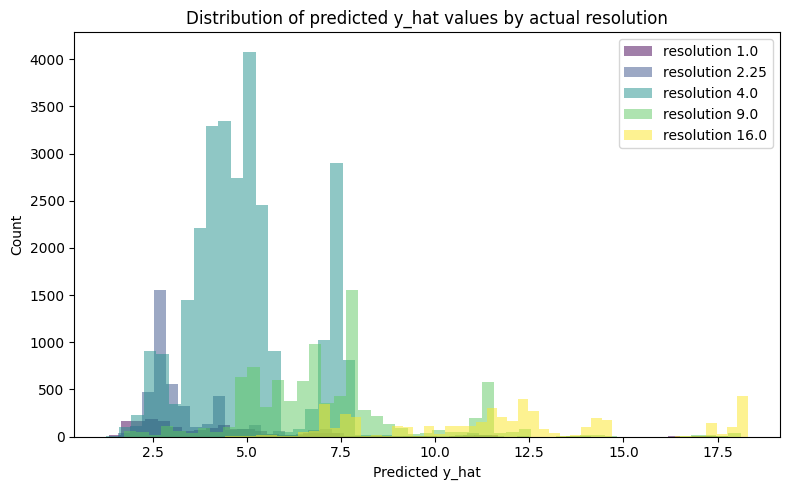

In [199]:
import matplotlib.pyplot as plt

def plot_yhat_by_class(y_hat, y):
    plt.figure(figsize=(8, 5))
    unique_classes = np.unique(y)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

    for cls, color in zip(unique_classes, colors):
        plt.hist(
            y_hat[y == cls],
            bins=50,
            alpha=0.5,
            color=color,
            label=f"resolution {cls}"
        )

    plt.title("Distribution of predicted y_hat values by actual resolution")
    plt.xlabel("Predicted y_hat")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_yhat_by_class(y_hat, y)


<span style="color: green">
I considered a number of variations in my choice of features (including non-linear data transformations, including exponentiating the output classes – see below). However, I ultimately decided that this data (a proxy of the backdwidth consumed per second) doesn't fully predict resolution. As graphed above, the distributions are not significantly separated on this spectrum: 240p and 360p almost completely overlap. Many of the bumps down to 240p or 360p may be explained by temporary network congestion: these events won't heavily affect total bandwidth, and therefore are insufficient for high accuracies.
</span>

### Prepare data for random forest classification
<span style="color: green;">

After determining that the linear classifier didn't work in practice, I moved on to trying a random forest classifier. Since I landed on this model as my final choice, I performed train/test splitting, as expected
</span>

In [327]:
chosen_feature_names = ["avg_flow_age", "bitrate", "current_chunk_iat", "n_chunks_up", "n_chunks_down", "previous_bitrate", "total_throughput_up", "total_throughput_down", "relative_timestamp", "up_down_ratio", "userAvgBytesInFlight", "parallel_flows"]
features = non_empty_df[chosen_feature_names]
labels = non_empty_df["resolution"]

In [330]:
def run_random_forest(features, labels, parameter_args):
    # Define features (X) and labels (y)
    X = features
    y = labels.apply(lambda x: f"{int(x)}p")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train model
    model = RandomForestClassifier(**parameter_args)
    model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"RandomForest Accuracy: {accuracy:.4f}")
    
    for cls in sorted(y.unique()):
        total = (y_test == cls).sum()
        correct = ((y_test == cls) & (y_pred == cls)).sum()
        print(f"{int(correct)}/{int(total)} {cls} samples correct")

    return model, X_test, y_test, y_pred

model, X_test, y_test, y_pred = run_random_forest(features, labels, {})

RandomForest Accuracy: 0.9393
910/924 1080p samples correct
159/324 240p samples correct
697/872 360p samples correct
5556/5648 480p samples correct
1702/1839 720p samples correct


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [331]:
# I used https://www.geeksforgeeks.org/machine-learning/hyperparameters-of-random-forest-classifier/#
# as a reference.
parameters = {
    "min_samples_leaf": 1,
    "n_estimators": 30, # while more marginally increases accuracy, it significantly increases runtime
    "max_features": "sqrt",
    # "min_samples_split": 5, # non-default values decreased accuracy
    "max_depth": 25,
}

model, X_test, y_test, y_pred = run_random_forest(features, labels, parameters)

RandomForest Accuracy: 0.9371
907/924 1080p samples correct
162/324 240p samples correct
703/872 360p samples correct
5536/5648 480p samples correct
1695/1839 720p samples correct


<span style="color: green">
Although accuracy remainded roughly the same after my hyperparameter tuning, the training speed increased dramatically. This would help with real-time packet analysis.
</span>

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

Final model achieved 93.71291766420319% accuracy
The model had an f1 score of 0.9345420259444714, which is quite good
Similar to the linear model case, there appeared to be significant misclassifications among resolutions 240-480p
Plotting the ROC/AUC curve for a multi-classification model requires additional technical model; many solutions recommend retraining with another class
Since we haven't covered this in class, I don't believe that I have the domain knowledge required to audit any code that I find via forums or an LLM
Instead, I've defaulted to just finding the raw score
0.9946564066924545


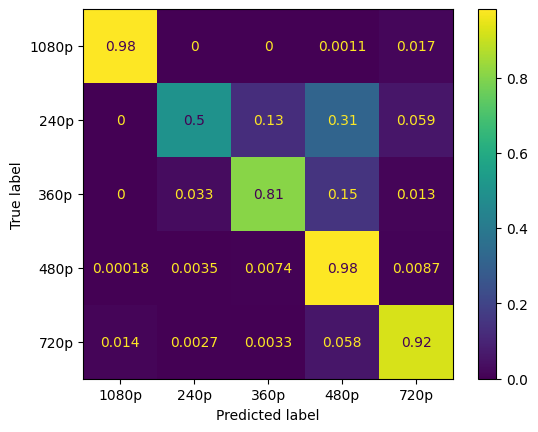

In [343]:
print(f"Final model achieved {accuracy_score(y_test, y_pred) * 100}% accuracy")
print(f"The model had an f1 score of {f1_score(y_test, y_pred, average='weighted')}, which is quite good")
print("Similar to the linear model case, there appeared to be significant misclassifications among resolutions 240-480p")
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=model.classes_).plot()

print("Plotting the ROC/AUC curve for a multi-classification model requires additional technical model; many solutions recommend retraining with another class")
print("Since we haven't covered this in class, I don't believe that I have the domain knowledge required to audit any code that I find via forums or an LLM")
print("Instead, I've defaulted to just finding the raw score")

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = model.predict_proba(X_test)  # list of arrays if multi-class
micro_roc_auc_ovr = roc_auc_score(
    y_test_bin,      # one-hot encoded true labels
    y_score,         # predicted probabilities
    multi_class="ovr",
    average="micro"
)
print(f"The roc_auc_score of the model is {micro_roc_auc_ovr}.")
"""To be candid, I'm not sure how this is implemented. I have a general sense of the restrictions on the classification methods
required to apply this model (especially that discrete outputs are incompatible with the metric). The snippet above was generated by
ChatGPT to fix the runtime error caused by:


micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_pred,
    multi_class="ovr",
    average="micro",
)

This matches what several online forum posts have said. I lack the technical background to verify this answer or interpret its meaning.
"""

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

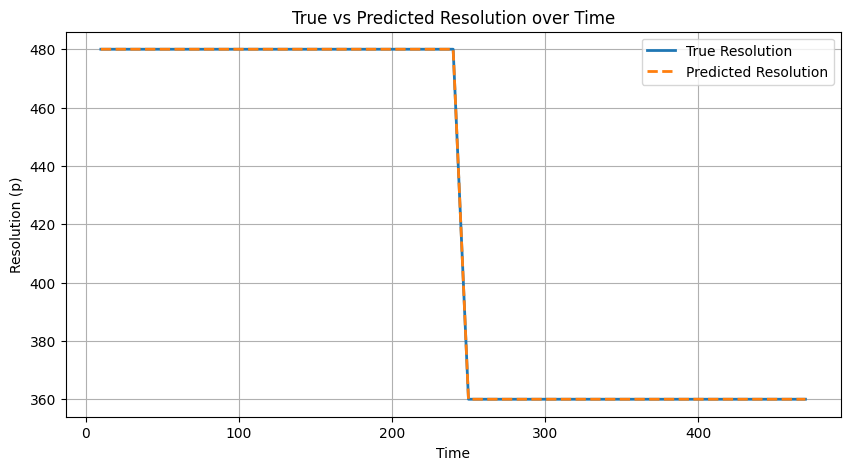

In [293]:
session = random.sample(list(labeled_ds["session_id"]), 1)[0]
selected_packets = labeled_ds[labeled_ds["session_id"] == session]
selected_packet_features = selected_packets[chosen_feature_names]

predictions = model.predict(selected_packet_features)

# Map resolutions from strings like "720p" → 720 (int)
y_true = selected_packets["resolution"]
y_pred = [int(str(p).rstrip("p")) for p in predictions]

# Plot the lines
plt.figure(figsize=(10, 5))
plt.plot(selected_packet_features["relative_timestamp"], y_true, label="True Resolution", linewidth=2)
plt.plot(selected_packet_features["relative_timestamp"], y_pred, label="Predicted Resolution", linewidth=2, linestyle="--")

# Style
plt.xlabel("Time")
plt.ylabel("Resolution (p)")
plt.title("True vs Predicted Resolution over Time")
plt.legend()
plt.grid(True)
plt.show()
